In [ ]:
#  Install required libraries (run this cell first)

!pip install librosa
!pip install pandas
!pip install tqdm


In [ ]:

import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
#    Set up the music directory path
music_dir = '/content/drive/MyDrive/DJ Project /Downloaded_Music'


In [ ]:

def get_music_files(directory):
    """Get all music files from the directory"""
    supported_formats = ['.mp3', '.wav', '.flac', '.m4a', '.aac', '.ogg']
    music_files = []

    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return music_files

    for file in os.listdir(directory):
        if any(file.lower().endswith(fmt) for fmt in supported_formats):
            music_files.append(os.path.join(directory, file))

    print(f"Found {len(music_files)} music files")
    return music_files

def extract_features(file_path, sr=22050, duration=30):
    """
    Extract comprehensive audio features from a music file

    Parameters:
    - file_path: path to the audio file
    - sr: sample rate (22050 Hz is standard for music analysis)
    - duration: duration in seconds to analyze (None for full file)
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Basic features
        features = {}
        features['filename'] = os.path.basename(file_path)
        features['duration'] = librosa.get_duration(y=y, sr=sr)

        # Spectral features
        # 1. MFCCs (Mel-frequency cepstral coefficients) - most important for music
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i}_std'] = np.std(mfccs[i])

        # 2. Spectral centroid (brightness)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_centroid_std'] = np.std(spectral_centroid)

        # 3. Spectral rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)

        # 4. Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)

        # 5. Chroma features (pitch class profiles)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for i in range(12):
            features[f'chroma_{i}_mean'] = np.mean(chroma[i])

        # Rhythm features
        # 6. Tempo
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo

        # 7. RMS Energy
        rms = librosa.feature.rms(y=y)
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)

        # 8. Spectral bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def extract_all_features(music_files, sample_duration=30):
    """Extract features from all music files"""
    all_features = []

    print(f"Extracting features from {len(music_files)} files...")

    for file_path in tqdm(music_files, desc="Processing files"):
        features = extract_features(file_path, duration=sample_duration)
        if features:
            all_features.append(features)

    return pd.DataFrame(all_features)

def visualize_features(df):
    """Create visualizations of the extracted features"""
    # Set up the plotting style
    plt.style.use('default')

    # 1. Tempo distribution
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.hist(df['tempo'], bins=20, alpha=0.7, color='blue')
    plt.title('Tempo Distribution')
    plt.xlabel('BPM')
    plt.ylabel('Count')

    # 2. Spectral centroid vs tempo
    plt.subplot(2, 3, 2)
    plt.scatter(df['tempo'], df['spectral_centroid_mean'], alpha=0.6)
    plt.title('Spectral Centroid vs Tempo')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Spectral Centroid')

    # 3. Energy (RMS) distribution
    plt.subplot(2, 3, 3)
    plt.hist(df['rms_mean'], bins=20, alpha=0.7, color='green')
    plt.title('Energy (RMS) Distribution')
    plt.xlabel('RMS Energy')
    plt.ylabel('Count')

    # 4. Duration distribution
    plt.subplot(2, 3, 4)
    plt.hist(df['duration'], bins=20, alpha=0.7, color='red')
    plt.title('Song Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')

    # 5. First MFCC vs Second MFCC
    plt.subplot(2, 3, 5)
    plt.scatter(df['mfcc_0_mean'], df['mfcc_1_mean'], alpha=0.6)
    plt.title('MFCC 0 vs MFCC 1')
    plt.xlabel('MFCC 0')
    plt.ylabel('MFCC 1')

    # 6. Correlation heatmap of key features
    plt.subplot(2, 3, 6)
    key_features = ['tempo', 'spectral_centroid_mean', 'rms_mean',
                   'mfcc_0_mean', 'mfcc_1_mean', 'zcr_mean']
    corr_matrix = df[key_features].corr()
    plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title('Feature Correlation Heatmap')
    plt.xticks(range(len(key_features)), key_features, rotation=45)
    plt.yticks(range(len(key_features)), key_features)

    plt.tight_layout()
    plt.show()



def load_and_preview_audio(file_path, duration=10):
    """Load and preview an audio file"""
    try:
        y, sr = librosa.load(file_path, duration=duration)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(np.linspace(0, duration, len(y)), y)
        plt.title(f'Waveform: {os.path.basename(file_path)}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(1, 2, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')

        plt.tight_layout()
        plt.show()

        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def find_similar_songs(features_df, target_idx, n_similar=5):
    """Find similar songs based on feature similarity"""
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics.pairwise import cosine_similarity

    # Select numerical features only
    numerical_features = features_df.select_dtypes(include=[np.number]).drop(['duration'], axis=1, errors='ignore')

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(numerical_features)

    # Calculate similarity
    similarities = cosine_similarity([features_scaled[target_idx]], features_scaled)[0]

    # Get most similar songs (excluding the target song itself)
    similar_indices = similarities.argsort()[-n_similar-1:-1][::-1]

    print(f"Songs similar to: {features_df.iloc[target_idx]['filename']}")
    for i, idx in enumerate(similar_indices):
        print(f"{i+1}. {features_df.iloc[idx]['filename']} (similarity: {similarities[idx]:.3f})")

    return similar_indices

Found 50 music files
Extracting features from 50 files...


Processing files: 100%|██████████| 50/50 [02:28<00:00,  2.97s/it]


Feature extraction completed!
Dataset shape: (50, 51)
Features extracted: ['filename', 'duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'zcr_mean', 'zcr_std', 'chroma_0_mean', 'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean', 'tempo', 'rms_mean', 'rms_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std']

Basic statistics:
       spectral_centroid_mean   rms_mean  duration
count               50.000000  50

ValueError: The 'color' keyword argument must have one color per dataset, but 50 datasets and 1 colors were provided

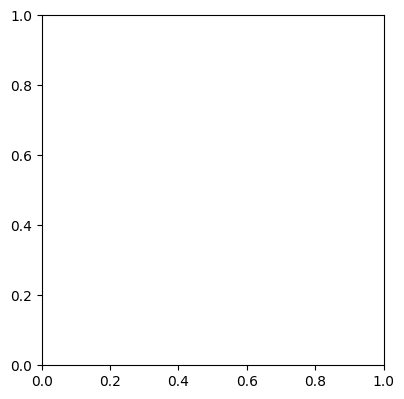

In [ ]:
# Main execution
if __name__ == "__main__":
    # Get all music files
    music_files = get_music_files(music_dir)

    if not music_files:
        print("No music files found. Please check the directory path.")
    else:
        # Extract features from all files
        # Note: Using 30 seconds sample for faster processing
        # Set duration=None to analyze full songs (will take longer)
        features_df = extract_all_features(music_files, sample_duration=30)

        if not features_df.empty:
            print(f"\nFeature extraction completed!")
            print(f"Dataset shape: {features_df.shape}")
            print(f"Features extracted: {features_df.columns.tolist()}")

            # Display basic statistics
            print("\nBasic statistics:")
            print(features_df[['tempo', 'spectral_centroid_mean', 'rms_mean', 'duration']].describe())

            # Save features to CSV
            features_df.to_csv('/content/drive/MyDrive/DJ Project /music_features.csv', index=False)
            print("\nFeatures saved to: /content/drive/MyDrive/DJ Project /music_features.csv")

            # Create visualizations
            visualize_features(features_df)

            # Show first few rows
            print("\nFirst 5 rows of extracted features:")
            print(features_df.head())
        else:
            print("No features could be extracted from the files.")